# Modul 7 Persamaan Diferensial Numerik: *Nonlinear Finite Difference*, PDP Eliptik & Hiperbolik

Kembali ke [Persamaan Diferensial Numerik](./pdnum2024genap.qmd)

(work in progress!)

Melanjutkan dari modul sebelumnya, untuk masalah nilai batas PDB, kita akan membahas metode

- *Nonlinear Finite Difference*

Kemudian, kita akan membahas metode numerik untuk menyelesaikan PDP (persamaan diferensial parsial) orde 2

- yang eliptik (persamaan Laplace / persamaan Poisson); dan

- yang hiperbolik (persamaan gelombang).

## *Nonlinear Finite Difference*

Metode ini digunakan untuk mengaproksimasi masalah nilai batas:

$$
\begin{gathered}
y^{\prime \prime}=f\left(x, y, y^{\prime}\right), \quad a \leq x \leq b \\
y(a)=\alpha, \quad y(b)=\beta
\end{gathered}
$$

dengan $f$ boleh berupa fungsi linier maupun nonlinier.

Metode ini bersifat iteratif, memanfaatkan yang namanya "metode Newton untuk sistem" yang dibahas di subbab 10.2 buku Burden, yang dibahas di mata kuliah Matematika Numerik. Daripada membahas secara umum mengenai metode Newton untuk sistem, kita cukup membahas bagaimana langkah-langkah metodenya khusus dalam penerapannya sebagai metode *nonlinear finite difference* untuk menyelesaikan masalah nilai batas.

Langkah-langkah metode *nonlinear finite difference* bisa ditulis sebagai berikut:

1.  Hitung rumus $f_y(x,y,y')$ (yaitu $\frac{\partial f}{\partial y}(x,y,y')$) dan rumus $f_{y'}(x,y,y')$ (yaitu $\frac{\partial f}{\partial y'}(x,y,y')$) secara analitik.

2. Tentukan toleransi $\varepsilon$, dan/atau maksimum banyaknya iterasi $M$.

3. Pastikan nilai $N$ dan *step size* $h$ sudah dimiliki. Biasanya hanya salah satu nilai yang diberikan (biasanya $N$). Hubungan antara keduanya adalah

    $$h = \frac{b-a}{N+1}$$

4. Ingat bahwa $w_0 = \alpha$ dan $w_{N+1} = \beta$. Kita perlu menentukan nilai-nilai $w_1, \dots, w_N$. Untuk nilai-nilai tersebut, pasang tebakan awal, berupa nilai-nilai di antara $\alpha$ dan $\beta$, sebagai berikut untuk $i = 1, \dots, N$:

    $$w_i = \alpha + i\left(\frac{\beta - \alpha}{b-a}\right)h$$

5. Susun suatu matriks tridiagonal berukuran $N \times N$ yang dinamakan matriks Jacobian, dengan entri
    $$J_{ij} = \begin{cases}
        -\left(1 + \frac{h}{2} f_{y'} \left(x_i, w_i, \frac{w_{i+1} - w_{i-1}}{2h}\right)\right) & \text{di bawah/kiri diagonal, baris ke-$i$} \\
        2 + h^2 f_{y} \left(x_i, w_i, \frac{w_{i+1} - w_{i-1}}{2h}\right) & \text{di diagonal, baris ke-$i$} \\
        -\left(1 - \frac{h}{2} f_{y'} \left(x_i, w_i, \frac{w_{i+1} - w_{i-1}}{2h}\right) \right) & \text{di atas/kanan diagonal, barsi ke-$i$} \\
        0 & \text{untuk semua elemen lainnya}
    \end{cases}$$

6. Susun vektor kolom bernama $d$ dengan $N$ baris, yang isinya sebagai berikut untuk $i = 1, \dots, N$:
    $$d_i = -w_{i-1} + 2w_i - w_{i+1} + h^2 f\left(x_i, w_i, \frac{w_{i+1}-w_{i-1}}{2h}\right)$$

7. Selesaikan SPL $Jv = -d$ (iya pakai minus), di mana vektor $v$ berisi nilai-nilai $v_1,\dots,v_N$ yang ingin diperoleh. Metode penyelesaian SPLnya terserah.

8. Perbarui vektor $w$ dengan menambahkan vektor $v$. Yaitu, nilai $w_1$ ditambahkan $v_1$, nilai $w_2$ ditambahkan $v_2$, dan seterusnya.

9. Sampai sini, selesai satu iterasi. Periksa apakah $\left|\left|v\right|\right| \le \varepsilon$ (atau periksa apakah sudah memenuhi banyaknya iterasi yang diminta). Kalau sudah terpenuhi, metode selesai. Kalau belum, masuk ke iterasi selanjutnya, yaitu melanjutkan kembali dari langkah 5, dengan nilai-nilai $w_1, \dots, w_N$ terbaru.

### *Function file* (dengan solusi SPL secara langsung)

Berikut ini, matriks Jacobian disusun dengan mempertimbangkan tiap elemen matriks, sehingga kompleksiasnya bisa dianggap $O(N^2)$:

In [105]:
function [x_grid, w_grid] = nonlinear_fd_langsung_on2(f, fy, fyp, a, b, N, alph, bet, tol, M)
  h = (b-a) / (N+1);
  x_grid = (a : h : b)'; % transpos juga agar menjadi vektor kolom
  x = x_grid(2 : N+1);
  w = zeros(N, 1);
  for i = 1 : N
    w(i) = alph + i * ((bet - alph)/(b-a)) * h;
  endfor
  
  % banyaknya iterasi
  k = 1;

  err = tol + 1;
  % selama belum memenuhi toleransi ataupun mencapai batas iterasi
  while (!(err <= tol) && k != M+1)
    % menyusun matriks Jacobian
    matriks_J = zeros(N, N);
    for i = 1 : N
      for j = 1 : N
        if (i == j+1) % kiri/bawah diagonal
          if (i == 1) % w(0) = alfa
            matriks_J(i, j) = -(1 + h/2 * fyp(x(i), w(i), (w(i+1) - alph)/(2*h)));
          elseif (i == N) % w(N+1) = beta
            matriks_J(i, j) = -(1 + h/2 * fyp(x(i), w(i), (bet - w(i-1))/(2*h)));
          else
            matriks_J(i, j) = -(1 + h/2 * fyp(x(i), w(i), (w(i+1) - w(i-1))/(2*h)));
          endif
        elseif (i == j) % pada diagonal
          if (i == 1) % w(0) = alfa
            matriks_J(i, j) = 2 + h^2 * fy(x(i), w(i), (w(i+1) - alph)/(2*h));
          elseif (i == N) % w(N+1) = beta
            matriks_J(i, j) = 2 + h^2 * fy(x(i), w(i), (bet - w(i-1))/(2*h));
          else
            matriks_J(i, j) = 2 + h^2 * fy(x(i), w(i), (w(i+1) - w(i-1))/(2*h));
          endif
        elseif (i == j-1) % kanan/atas diagonal
          if (i == 1) % w(0) = alfa
            matriks_J(i, j) = -(1 - h/2 * fyp(x(i), w(i), (w(i+1) - alph)/(2*h)));
          elseif (i == N) % w(N+1) = beta
            matriks_J(i, j) = -(1 - h/2 * fyp(x(i), w(i), (bet - w(i-1))/(2*h)));
          else
            matriks_J(i, j) = -(1 - h/2 * fyp(x(i), w(i), (w(i+1) - w(i-1))/(2*h)));
          endif
        else
          matriks_J(i, j) = 0;
        endif
      endfor
    endfor
    
    % menyusun vektor d
    d = zeros(N, 1);
    % khusus baris pertama
    i = 1;
    d(i) = -alph + 2 * w(i) - w(i+1) + h^2 * f(x(i), w(i), (w(i+1) - alph)/(2*h));
    for i = 2 : (N-1)
      d(i) = -w(i-1) + 2 * w(i) - w(i+1) + h^2 * f(x(i), w(i), (w(i+1) - w(i-1))/(2*h));
    endfor
    % khusus baris terakhir
    i = N;
    d(i) = -w(i-1) + 2 * w(i) - bet + h^2 * f(x(i), w(i), (bet - w(i-1))/(2*h));
    
    % selesaikan SPL
    v = matriks_J \ (-d);
    
    % update w
    w = w + v;

    % hitung error dengan norm Euclid
    err = sum(v.^2);

    k += 1; % lanjut ke iterasi selanjutnya
  endwhile

  % gabungkan w_0 (alfa), dengan w_1, ..., w_N, dengan w_{N+1} (beta)
  w_grid = [alph; w; bet];
endfunction

Daripada mempertimbangkan tiap elemen di matriks Jacobian, kita bisa isi matriksnya dengan nol semua terlebih dahulu, kemudian melihat per baris saja dan hanya mempertimbangkan elemen diagonal dan kolom sebelum/setelah diagonal (karena matriksnya tridiagonal). Kodenya menjadi seperti berikut:

In [107]:
function [x_grid, w_grid] = nonlinear_fd_langsung(f, fy, fyp, a, b, N, alph, bet, tol, M)
  h = (b-a) / (N+1);
  x_grid = (a : h : b)'; % transpos juga agar menjadi vektor kolom
  x = x_grid(2 : N+1);
  w = zeros(N, 1);
  for i = 1 : N
    w(i) = alph + i * ((bet - alph)/(b-a)) * h;
  endfor
  
  % banyaknya iterasi
  k = 1;

  err = tol + 1;
  % selama belum memenuhi toleransi ataupun mencapai batas iterasi
  while (!(err <= tol) && k != M+1)
    % menyusun matriks Jacobian
    matriks_J = zeros(N, N); % isi nol semua dulu
    for i = 1 : N % untuk tiap baris ke-i, dengan i = 1, ..., N
      % kiri/bawah diagonal (kecuali di baris pertama)
      if (i == N) % w(N+1) = beta
        matriks_J(i, i-1) = -(1 + h/2 * fyp(x(i), w(i), (bet - w(i-1))/(2*h)));
      elseif (i != 1) % rumus biasa
        matriks_J(i, i-1) = -(1 + h/2 * fyp(x(i), w(i), (w(i+1) - w(i-1))/(2*h)));
      endif

      % pada diagonal
      if (i == 1) % w(0) = alfa
        matriks_J(i, i) = 2 + h^2 * fy(x(i), w(i), (w(i+1) - alph)/(2*h));
      elseif (i == N) % w(N+1) = beta
        matriks_J(i, i) = 2 + h^2 * fy(x(i), w(i), (bet - w(i-1))/(2*h));
      else % rumus biasa
        matriks_J(i, i) = 2 + h^2 * fy(x(i), w(i), (w(i+1) - w(i-1))/(2*h));
      endif

      % kanan/atas diagonal (kecuali di baris terakhir)
      if (i == 1) % w(0) = alfa
        matriks_J(i, i+1) = -(1 - h/2 * fyp(x(i), w(i), (w(i+1) - alph)/(2*h)));
      elseif (i != N) % rumus biasa
        matriks_J(i, i+1) = -(1 - h/2 * fyp(x(i), w(i), (w(i+1) - w(i-1))/(2*h)));
      endif
    endfor
    
    % menyusun vektor d
    d = zeros(N, 1);
    % khusus baris pertama
    i = 1;
    d(i) = -alph + 2 * w(i) - w(i+1) + h^2 * f(x(i), w(i), (w(i+1) - alph)/(2*h));
    for i = 2 : (N-1)
      d(i) = -w(i-1) + 2 * w(i) - w(i+1) + h^2 * f(x(i), w(i), (w(i+1) - w(i-1))/(2*h));
    endfor
    % khusus baris terakhir
    i = N;
    d(i) = -w(i-1) + 2 * w(i) - bet + h^2 * f(x(i), w(i), (bet - w(i-1))/(2*h));
    
    % selesaikan SPL
    v = matriks_J \ (-d);
    
    % update w
    w = w + v;

    % hitung error dengan norm Euclid
    err = sum(v.^2);

    k += 1; % lanjut ke iterasi selanjutnya
  endwhile

  % gabungkan w_0 (alfa), dengan w_1, ..., w_N, dengan w_{N+1} (beta)
  w_grid = [alph; w; bet];
endfunction

### Contoh 1

Gunakan metode beda hingga nonlinier *(nonlinear finite difference)* dengan $h=0.1$ dan toleransi $10^{-4}$ untuk mengaproksimasi *Boundary Value Problem* (BVP) / Masalah Nilai Batas (MNB) berikut:
$$
\begin{aligned}
y^{\prime \prime} & =y^{\prime}+2(y-\ln x)^3-\frac{1}{x}, \quad 2 \leq x \leq 3 \\
y(2) & =\frac{1}{2}+\ln 2, \quad y(3)=\frac{1}{3}+\ln 3
\end{aligned}
$$

Solusi eksak:

$$y(x)=\frac{1}{x}+\ln x$$

Hint:

$$y'' = f\left(x,y,y'\right) = y'+2(y-\ln x)^3-\frac{1}{x}$$

$$f_{y}\left(x,y,y'\right) = \frac{\partial f}{\partial y} \left(x,y,y'\right) = 6\left(y - \ln{x}\right)^2$$

$$f_{y'}\left(x,y,y'\right) = \frac{\partial f}{\partial y'} \left(x,y,y'\right) = 1$$

Tabel aproksimasi, solusi y(x), dan error:
ans =

   2.000000000000000   1.193147180559945   1.193147180559945                   0
   2.100000000000000   1.218136665897076   1.218127820919853   0.000008844977223
   2.200000000000000   1.243017438585886   1.243002814909725   0.000014623676161
   2.300000000000000   1.267709758540398   1.267691731630756   0.000018026909642
   2.400000000000000   1.292154898557824   1.292135404020567   0.000019494537257
   2.500000000000000   1.316310046093640   1.316290731874155   0.000019314219485
   2.600000000000000   1.340144522402694   1.340126829642821   0.000017692759873
   2.700000000000000   1.363636945192896   1.363622143380654   0.000014801812242
   2.800000000000000   1.386773073873609   1.386762274324015   0.000010799549594
   2.900000000000000   1.409544153003318   1.409538323199325   0.000005829803994
   3.000000000000000   1.431945622001443   1.431945622001443                   0



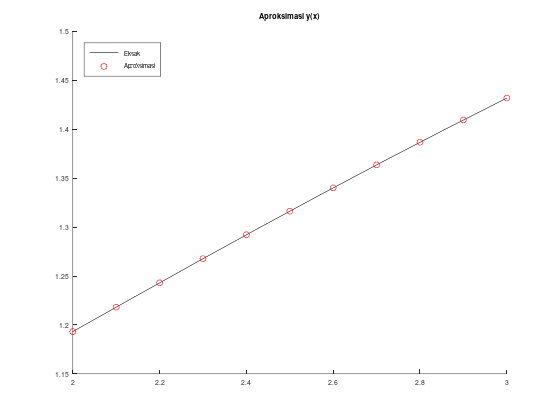

In [109]:
f = @(x,y,yp) yp + 2*(y-log(x)).^3 - 1./x ; % fungsi f pada y=f(x,y,y')
fy = @(x,y,yp) 6*(y-log(x)).^2; % turunan fungsi f terhadap y
fyp = @(x,y,yp) 1; % turunan fungsi f terhadap y prime, yaitu y'
a = 2; % left boundary
b = 3; % right boundary
N = 9; % banyaknya partisi (pilih N=9 sehingga h=0.1)
alph = 0.5 + log(2); % y(a)
bet = 1/3 + log(3); % y(b)
tol = 10^(-4); % toleransi nilai (untuk kriteria stop)
M = 30; % maksimum iterasi

[x_grid, w_grid] = nonlinear_fd_langsung(f, fy, fyp, a, b, N, alph, bet, tol, M);

% solusi eksak
sln = @(x) 1./x + log(x);
y_eksak = sln(x_grid);

% menghitung error
err_w = abs(y_eksak - w_grid);

% tampilkan tabel
format long;
disp("Tabel aproksimasi, solusi y(x), dan error:");
[x_grid, w_grid, y_eksak, err_w]
format;

hold on;
fplot(sln, [a, b], 'k');
scatter(x_grid, w_grid, 'r');
title("Aproksimasi y(x)");
legend("Eksak", "Aproksimasi");
legend("location", "northwest");

### Contoh 2

Selesaikan maslaah nilai batas berikut

$$y'' = \frac{1}{8} \left(32 + 2x^3 - yy'\right), \quad 1 \le x \le 3$$
$$y(1) = 17, \quad y(3) = \frac{43}{3}$$

dengan $h=0.1$, toleransi $10^{-8}$, dan maksimum iterasi $M=30$. Bandingkan hasilnya dengan solusi eksak

$$y(x) = x^2 + \frac{16}{x}$$

Hint:

$$y'' = f(x, y, y') = \frac{1}{8} \left(32 + 2x^3 - yy'\right)$$

$$f_{y} (x, y, y') = \frac{\partial f}{\partial y} (x, y, y') = -\frac{1}{8} y'$$

$$f_{y'} (x, y, y') = \frac{\partial f}{\partial y'} (x, y, y') = -\frac{1}{8} y$$

Tabel aproksimasi, solusi y(x), dan error:
ans =

 Columns 1 through 3:

   1.000000000000000e+00   1.700000000000000e+01   1.700000000000000e+01
   1.100000000000000e+00   1.575450253529389e+01   1.575545454545455e+01
   1.200000000000000e+00   1.477173965356983e+01   1.477333333333333e+01
   1.300000000000000e+00   1.399567743713438e+01   1.399769230769231e+01
   1.400000000000000e+00   1.338629656205142e+01   1.338857142857143e+01
   1.500000000000000e+00   1.291425241252499e+01   1.291666666666667e+01
   1.600000000000000e+00   1.255753822750665e+01   1.256000000000000e+01
   1.700000000000000e+00   1.229932628240154e+01   1.230176470588235e+01
   1.800000000000000e+00   1.212652886701783e+01   1.212888888888889e+01
   1.900000000000000e+00   1.202881380980783e+01   1.203105263157895e+01
   2.000000000000000e+00   1.199791542246045e+01   1.200000000000000e+01
   2.100000000000000e+00   1.202714237122990e+01   1.202904761904762e+01
   2.200000000000000e+00   1.211101980435058e+01   

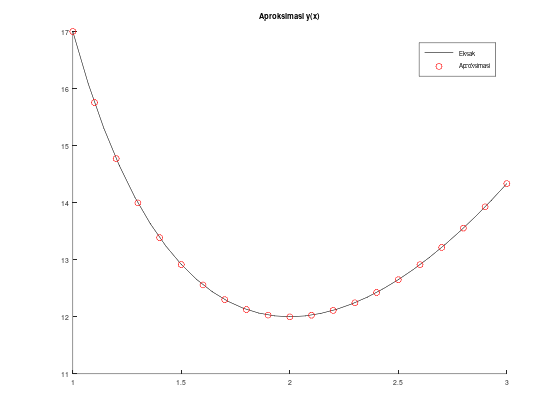

In [113]:
f = @(x, y, yp) ((1/8)*(32 + 2 * x.^3 - y .* yp));
fy = @(x, y, yp) (-yp/8);
fyp = @(x, y, yp) (-y/8);
a = 1;
b = 3;
h = 0.1;
N = (b - a)/h - 1;
alph = 17;
bet = 43/3;
tol = 10^(-8);
M = 30;

[x_grid, w_grid] = nonlinear_fd_langsung(f, fy, fyp, a, b, N, alph, bet, tol, M);

% solusi eksak
sln = @(x) ((x .^ 2) + ((16 ./ x)));
y_eksak = sln(x_grid);

% menghitung error
err_w = abs(y_eksak - w_grid);

% tampilkan tabel
format long;
disp("Tabel aproksimasi, solusi y(x), dan error:");
[x_grid, w_grid, y_eksak, err_w]
format;

hold on;
fplot(sln, [a, b], 'k');
scatter(x_grid, w_grid, 'r');
title("Aproksimasi y(x)");
legend("Eksak", "Aproksimasi");
legend('location', 'northeast');

## Plot tiga dimensi dan *grid*

Misalnya kita ingin membuat plot fungsi $u(x,y) = 4x + y$, setidaknya di titik-titik $x = 0,1,2,3$ dan $y = 0, 1, 2$. (Materi ini bisa dianggap perumuman dari materi *plotting* dua dimensi di [Modul 2](./modul2.ipynb); kalau lupa, mungkin bisa baca itu dulu.)

Pertama-tama, kita bisa membuat *array* untuk nilai-nilai $x$ dan untuk nilai-nilai $y$ yang kita ingin gunakan untuk *plotting*

In [6]:
x_arr = [0, 1, 2, 3]
y_arr = [0, 1, 2]

x_arr =

   0   1   2   3

y_arr =

   0   1   2



Apabila fungsi $u(x,y) = 4x + y$ dihitung di semua titik tersebut, bentuknya akan berupa *grid*, agar semua kemungkinan nilai $x$ dicoba dengan semua kemungkinan nilai $y$.

Caranya, kita susun terlebih dahulu dua *grid*, yaitu satu *grid* untuk nilai $x$ yang berisi nilai $x$ di posisi yang sesuai, dan satu *grid* untuk nilai $y$ yang berisi nilai $y$ di posisi yang sesuai. Ada fungsi Octave untuk melakukan ini, yaitu `meshgrid` yang bisa digunakan sebagai berikut.

In [7]:
[x_grid, y_grid] = meshgrid(x_arr, y_arr)

x_grid =

   0   1   2   3
   0   1   2   3
   0   1   2   3

y_grid =

   0   0   0   0
   1   1   1   1
   2   2   2   2



Perhatikan,

- untuk posisi pertama $x$, yaitu dengan $x=0$, satu kolom itu semuanya diisi $x=0$. Untuk posisi kedua, satu kolom itu semuanya diisi $x=1$. Begitu juga untuk $x=2$ dan $x=3$. Arahnya dari kiri ke kanan.

- untuk *grid* $y$, mirip dengan *grid* $x$, tetapi arahnya dari atas ke bawah (bukan bawah ke atas).

Setelah itu, barulah kita buat *grid* untuk hasilnya yaitu *grid* untuk $u$, dengan menerapkan fungsi $u$ menggunakan *grid* $x$ dan *grid* $y$ tersebut.

In [8]:
% contoh fungsi yang ingin kita coba
u = @(x, y) (4 * x + y);

In [9]:
% menggunakan fungsinya untuk memperoleh grid u dari grid x dan grid y
u_grid = u(x_grid, y_grid)

u_grid =

    0    4    8   12
    1    5    9   13
    2    6   10   14



Terakhir, kita tinggal menggambarnya menggunakan fungsi `mesh` seperti berikut:

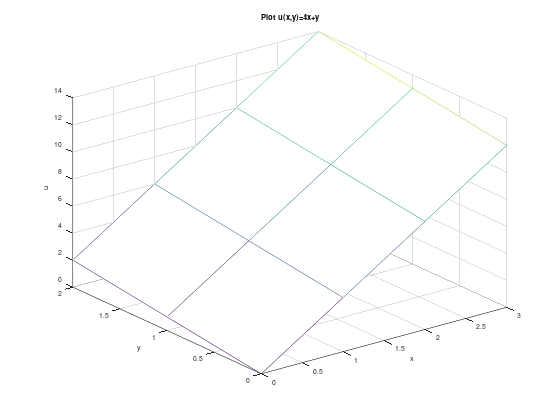

In [11]:
mesh(x_arr, y_arr, u_grid);
title("Plot u(x,y)=4x+y");
xlabel("x");
ylabel("y");
zlabel("u");

Perhatikan,

- walaupun tadi arah di *grid* $y$ adalah dari atas ke bawah, gambarnya masih dari bawah ke atas seperti biasanya (perhatikan sumbunya).

- walaupun tadi kita libatkan `x_grid` dan `y_grid` dalam perhitungan untuk memperoleh `u_grid`, pada akhirnya, yang digunakan untuk *plot* adalah `x_arr` dan `y_arr`

Ketika nilai-nilai `u_grid` ditampilkan, ia ditampilkan sebagai matriks (nilai $y$ dari atas ke bawah), sehingga mungkin arahnya kurang sesuai dengan gambar (nilai $y$ dari bawah ke atas), seperti terbalik.

Ada fungsi Octave untuk mem-*flip* atau membalik arah atas-bawah ini, yaitu `flipud` (*flip up-down*)

In [12]:
flipud(u_grid)

ans =

    2    6   10   14
    1    5    9   13
    0    4    8   12



Ketika ditampilkan seperti ini, nilai-nilai `u_grid` terlihat cocok dengan gambar.

Namun, misalkan kita memerlukan nilai $u(2, 1)$. Bagaimana cara membacanya dari *grid*?

$x=2$ ada di indeks 3 di `x_arr`

In [18]:
find(x_arr == 2)

ans = 3


$y = 1$ ada di indeks 2 di `y_arr`

In [19]:
find(y_arr == 1)

ans = 2


Sehingga nilai $u(2,1)$ seharusnya ada di indeks (3,2) dari `u_grid`...

In [22]:
u_grid(3, 2)

ans = 6


Hmm, kok aneh? Harusnya kan $u(2,1) = 4(2)+1 = 9$?

Karena satu dan lain hal, kita perlu mentranspos matriks *grid* nya terlebih dahulu:

In [23]:
u_grid'(3, 2)

ans = 9


Selama berurusan dengan PDP secara numerik, seringkali akan seperti itu; matriks untuk menyimpan/mengakses hasil perhitungan adalah transpos dari matriks yang diberikan ke fungsi `mesh`.

Kali ini, matriks `u_grid` menyimpan nilai-nilai untuk `mesh`, sehingga perlu ditranspos untuk keperluan mengakses hasil perhitungan. Nanti bisa juga sebaliknya, yaitu dimiliki matriks yang menyimpan hasil perhitungan, sehingga perlu ditranspos ketika ingin menggunakan `mesh`.

(Terlebih lagi, orientasi matriks untuk menampilkan nilai-nilai di *grid* dengan `flipud` akan sama dengan orientasi matriks untuk fungsi `mesh`. Jadi, kalau nantinya perlu ditranspos ketika ingin menggunakan `mesh`, kita juga perlu mentranspos ketika ingin menggunakan `flipud` untuk menampilkan nilai-nilai di *grid*.)

Mengapa harus berurusan dengan transpos? Mari kita lihat lagi bentuk matriks `u_grid`

In [26]:
u_grid

u_grid =

    0    4    8   12
    1    5    9   13
    2    6   10   14



Nilai 9 ada di mana? Harusnya di indeks (3,2). Kalau kita bayangkan itu adalah *grid* yang terbalik secara atas-bawah. Berarti, dari ujung kiri-atas yaitu indeks (1,1), kita ke kanan dua langkah, lalu ke bawah satu langkah.

Perhatikan: ke kanan dua langkah adalah **perpindahan kolom**, dan ke bawah satu langkah adalah **perpinahan baris**. Sedangkan, urutan indeks dalam mengakses nilai pada matriks aalah baris dulu, baru kolom. Karena dimensinya terbalik seperti itu, kita perlu mentranspos sebelum mengakses nilainya.

Kalau kita transpos dulu,

In [27]:
u_grid'

ans =

    0    1    2
    4    5    6
    8    9   10
   12   13   14



barulah kita bisa menggunakan indeks (3,2), yaitu di baris ke-3, kolom ke-2.

In [28]:
u_grid'(3,2)

ans = 9


Sedikit tambahan: alternatif dari fungsi `mesh` adalah fungsi `surf`

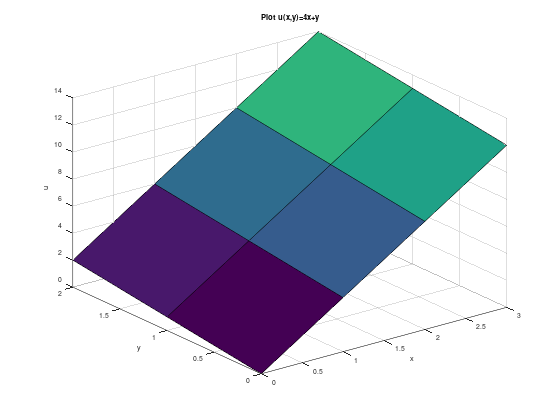

In [17]:
surf(x_arr, y_arr, u_grid);
title("Plot u(x,y)=4x+y");
xlabel("x");
ylabel("y");
zlabel("u");

Bedanya, fungsi `surf` memberi warna seperti itu. Walaupun terlihat bagus, mungkin *plot*nya malah menjadi lebih sulit dibaca, sehingga kita akan tetap menggunakan `mesh`

## PDP Eliptik/Laplace/Poisson

### Bentuk umum persamaan Laplace

Di mata kuliah Persamaan Diferensial Numerik, PDP orde 2 eliptik yang dibahas adalah persamaan Laplace, atau juga disebut persamaan Poisson.

Bentuk umum dari persamaan Laplace bisa ditulis
$$\frac{\partial^2 u}{\partial x^2}\left(x,y\right) + \frac{\partial^2 u}{\partial y^2}\left(x,y\right) = f\left(x,y\right), \quad a < x < b, \quad c < y < d$$
$$u\left(x, c\right) = g\left(x, c\right), \quad u\left(x, d\right) = g\left(x, d\right), \quad a \le x \le b$$
$$u\left(a, y\right) = g\left(a, y\right), \quad u\left(b, y\right) = g\left(b, y\right), \quad c \le y \le d$$
yang disertai nilai *step size* $h$ (yaitu $\Delta x$) dan nilai *step size* $k$ (yaitu $\Delta y$).

Perhatikan bahwa ada *source function* $f\left(x,y\right)$ (yang bisa saja bernilai nol) dan ada syarat batas semua sisi (karena PDP ini dalam variabel $x,y$).

Selain itu, semua syarat batas seolah-olah diberikan oleh satu fungsi $g$. Namun, biasanya, syarat batas bawah, atas, kiri, dan kanan yang diketahui tampak seperti fungsi yang berbeda-beda (walaupun sebenarnya digunakan satu fungsi yang sama).

Oleh karena itu, untuk kebutuhan praktikum, kita bisa menuliskan bentuk umum persamaan Laplace sebagai berikut:

$$\frac{\partial^2 u}{\partial x^2}\left(x,y\right) + \frac{\partial^2 u}{\partial y^2}\left(x,y\right) = f\left(x,y\right), \quad a < x < b, \quad c < y < d$$
$$u\left(x, c\right) = \text{db}\left(x, c\right), \quad u\left(x, d\right) = \text{ub}\left(x, d\right), \quad a \le x \le b$$
$$u\left(a, y\right) = \text{lb}\left(a, y\right), \quad u\left(b, y\right) = \text{rb}\left(b, y\right), \quad c \le y \le d$$

Keterangan:

- `db` bisa diingat *down boundary condition*, maksudnya syarat batas bawah

- `ub` bisa diingat *upper boundary condition*, maksudnya syarat batas atas

- `lb` bisa diingat *left boundary condition*, maksudnya syarat batas kiri

- `rb` bisa diingat *right boundary condition*, maksudnya syarat batas kanan

Kita memberi nama yang berbeda-beda untuk fungsi-fungsi syarat batas ini agar lebih mudah nantinya ketika ingin menginput syarat batas.

Lebih lanjut, batasan interval bisa kita tulis

$$\text{xb} < x < \text{xu}, \quad \text{yb} < y < \text{yu}$$

- `xb` bisa diingat "$x$ (below)"

- `xu` bisa diingat "$x$ (upper)"

- `yb` bisa diingat "$y$ (below)"

- `yu` bisa diingat "$y$ (upper)"

### Ide utama

Metode yang umum digunakan dalam penyelesaian PDP secara numerik adalah metode *finite difference*, melibatkan yang namanaya **diskretisasi**, yaitu memecah tiap interval menjadi titik-titik.

Untuk PDP dalam variabel $x$ dan $y$, diskretisasi dilakukan sebagai berikut:

- interval $a \le x \le b$ dipecah menjadi titik-titik $x_i = a + ih$ dengan $i=0,\dots,m$, yaitu menjadi sebanyak $(m+1)$ titik

- interval $c \le y \le d$ dipecah menjadi titik-titik $y_j = c + jk$ dengan $j=0,\dots,N$, yaitu menjadi sebanyak $(N+1)$ titik

Kemudian, hasil aproksimasi solusi PDP pada titik $\left(x_i, y_j\right)$ ditulis $w_{i,j}$

(atau terkadang ditulis $u_i^j$, atau bahkan $u_j^n$ untuk titik $\left(x_j, y_n\right)$)

Diskretisasi untuk penylesaian PDP secara numerik bisa dipandang sebagai perumuman dari proses diskretisasi untuk penyelesaian PDB secara numerik, yaitu perumuman dari $t_i = a + ih$ atau terkadang ditulis $x_i = a + ih$.

Untuk persamaan Laplace, hanya ada satu metode *finite difference*, yang diawali dengan permisalan nilai lambda berikut:

$$\lambda = \left(\frac{h^2}{k^2}\right) = \frac{h^2}{k^2}$$

Ide utama dari metode *finite difference* untuk persamaan Laplace adalah menuliskan rumus *finite difference* berikut untuk tiap $i=1,\dots,(m-1)$ dan juga untuk tiap $j=1,\dots,(N-1)$:

$$2\left(\lambda+1\right) w_{i,j} - \left(w_{i+1,j} + w_{i-1,j}\right) - \lambda\left(w_{i,j+1} + w_{i,j-1}\right) = -h^2 f\left(x_i, y_j\right)$$

Setelah menuliskan rumus tersebut sebanyak $(m-1)\times(N-1)$ kali, perhatikan bahwa ada beberapa nilai syarat batas yang sudah diketahui dan berupa konstana, misalnya batas bawah $w_{0,0}, w_{1,0}, w_{2,0}, \dots$ dan batas kiri $w_{0,0}, w_{0,1}, w_{0,2}, \dots$

Nilai-nilai yang sudah diketahui tersebut bisa langsung dimasukkan ke dalam persamaan-persamaannya.

Dengan demikian, diperoleh SPL yang terdiri dari $(m-1)\times(N-1)$ buah variabel, yaitu variabel-variabel $w_{i,j}$ untuk tiap $i=1,\dots,(m-1)$ dan tiap $j=1,\dots,(N-1)$.

SPL ini dapat diselesaikan untuk memperoleh semua nilai $w_{i,j}$ sekaligus.

(Dalam penggunaan Octave, indeks $0,\dots,m$ dan $0,\dots,N$ digeser menjadi $1,\dots,(m+1)$ dan $1,\dots,(N+1)$ karena indeks *array* yang dimulai dari 1.)

### Penggunaan metode Gauss-Seidel

Sayangnya, tidak ada cara cepat untuk menyusun SPL tersebut. Apabila penyelesaian dilakukan secara manual, tidak masalah; kita tinggal susun SPLnya secara manual, hingga bisa disusun dalam bentuk matriks, baru menyelesaikan SPL dalam bentuk matriks tersebut (yang bisa dilakukan dengan metode langsung seperti OBE, invers, ataupun metode iteratif, atau dengan bantuan komputer).

Apabila PDP eliptik ingin diselesaikan secara program, daripada harus menyusun bentuk SPL secara rapi terlebih dahulu, kita bisa menggunakan metode penyelesaian SPL yang iteratif. Contohnya, metode Gauss-Seidel bisa langsung menggunakan bentuk umumnya, yaitu

$$2\left(\lambda+1\right) w_{i,j} - \left(w_{i+1,j} + w_{i-1,j}\right) - \lambda\left(w_{i,j+1} + w_{i,j-1}\right) = -h^2 f\left(x_i, y_j\right)$$

yang dipindahruaskan agar diperoleh

$$2\left(\lambda+1\right) w_{i,j} = \left(w_{i+1,j} + w_{i-1,j}\right) + \lambda\left(w_{i,j+1} + w_{i,j-1}\right) -h^2 f\left(x_i, y_j\right)$$

$$w_{i,j} = \frac{1}{2\left(\lambda+1\right)}\left(w_{i+1,j} + w_{i-1,j} + \lambda\left(w_{i,j+1} + w_{i,j-1}\right) -h^2 f\left(x_i, y_j\right)\right)$$

Mengingat dari mata kuliah Metode Numerik, metode Gauss-Seidel memang memanfaatkan bentuk persamaan yang seperti ini.

Menggunakan metode Gauss-Seidel, kita tinggal memasang tebakan awal untuk tiap variabel $w_{i,j}$ (yang bisa dipasang nol semua menurut buku Burden), kemudian mengulang-ulang perhitungan menggunakan rumus tersebut hingga konvergen.

### *Function file*

In [1]:
function [x, y, w] = eliptik_iteratif(db, ub, lb, rb, f, xb, xu, yb, yu, h, k, tol, M)
  x = xb : h : xu;
  y = yb : k : yu;
  m_plus_1 = length(x);
  N_plus_1 = length(y);
  
  % susun matriks solusi w_{i,j}
  % awalnya berisi nol semua agar sekaligus mengisi tebakan awal
  w = zeros(m_plus_1, N_plus_1);

  % isi syarat batas (saat ini masih nol semua)
  for i = 1 : m_plus_1 % digeser dari i=0,...,m jadi i=1,...,(m+1)
    w(i, 1)         = db(x(i), yb);
    w(i, N_plus_1)  = ub(x(i), yu);
  endfor
  for j = 2 : (N_plus_1 - 1) % digeser dari j=1,...,(N-1) jadi j=2,...,N
    w(1, j)         = lb(xb, y(j));
    w(m_plus_1, j)  = rb(xu, y(j));
  endfor
  
  % lakukan iterasi metode Gauss-Seidel untuk semua nilai w_{i,j} lainnya
  lambd = (h/k)^2;
  err = tol + 1; % errornya sembarang dulu, yang penting masuk loop
  k = 1;
  while (!(err <= tol) && (k != M+1))
    old_values = w(2 : m_plus_1 - 1,  2 : N_plus_1 - 1); % selain syarat batas
    for i = 2 : (m_plus_1 - 1) % digeser dari i=1,...,(m-1) jadi i=2,...,m
      for j = 2 : (N_plus_1 - 1) % digeser dari j=1,...,(N-1) jadi j=2,...,N
        w(i, j) = w(i+1, j) + w(i-1, j) + lambd * (w(i, j+1) + w(i, j-1));
        w(i, j) += - h^2 * f(x(i), y(j));
        w(i, j) /= 2 * (lambd + 1);
      endfor
    endfor
    new_values = w(2 : m_plus_1 - 1,  2 : N_plus_1 - 1); % selain syarat batas
    err = max(max(abs(old_values - new_values))); % norm infinity
    k += 1; % lanjut ke iterasi selanjutnya
  endwhile
endfunction

### Contoh 1

Selesaikan PDP eliptik

$$\frac{\partial^2 u}{\partial x^2} \left(x,y\right) + \frac{\partial^2 u}{\partial y^2} \left(x,y\right) = 0, \quad 0 < x < 0.5, \quad 0 < y < 0.5$$

dengan syarat batas

$$u(x,0) = 0, \quad u(x, 0.5) = 200x, \quad 0 \le x \le 0.5$$

$$u(0,y) = 0, \quad u(0.5, y) = 200y, \quad 0 \le y \le 0.5$$

secara numerik dengan *step size* $h = k = 0.125$, toleransi $10^{-8}$, dan maksimum iterasi $M=50$.

Grid nilai aproksimasi:
          0    25.0000    50.0000    75.0000   100.0000
          0    18.7500    37.5000    56.2500    75.0000
          0    12.5000    25.0000    37.5000    50.0000
          0     6.2500    12.5000    18.7500    25.0000
          0          0          0          0          0


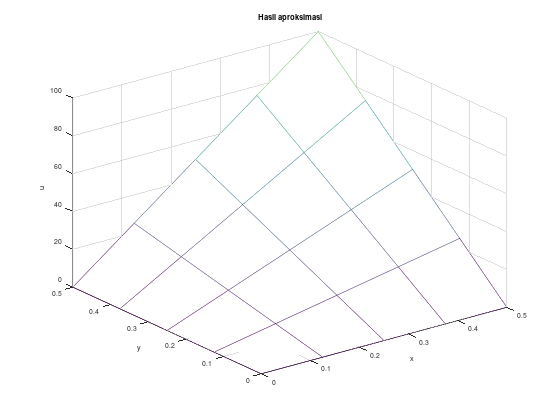

In [10]:
db = @(x,y) 0;
ub = @(x,y) 200*x;
lb = @(x,y) 0;
rb = @(x,y) 200*y;
f = @(x,y) 0;
xb = 0;
xu = 0.5;
yb = 0;
yu = 0.5;
h = 0.125;
k = 0.125;
tol = 10^(-8);
M = 50;

[x_arr, y_arr, w] = eliptik_iteratif(db, ub, lb, rb, f, xb, xu, yb, yu, h, k, tol, M);

% menampilkan nilai aproksimasi dalam bentuk seperi grid
disp("Grid nilai aproksimasi:");
disp(flipud(w'));

% gambar mesh hasil aproksimasi
figure;
mesh(x_arr, y_arr, w');
title("Hasil aproksimasi");
xlabel("x");
ylabel("y");
zlabel("u");

### Contoh 2

Selesaikan PDP eliptik

$$\frac{\partial^2 u}{\partial x^2} \left(x,y\right) + \frac{\partial^2 u}{\partial y^2} \left(x,y\right) = xe^y, \quad 0 < x < 2, \quad 0 < y < 1$$

dengan syarat batas

$$u(x, 0) = x, \quad u(x, 1) = ex, \quad 0 \le x \le 2$$

$$u(0, y) = 0, \quad u(2, y) = 2e^y, \quad 0 \le y \le 1$$

secara numerik dengan $m = 6$ dan $N = 5$, menggunakan metode Gauss-Seidel dengan toleransi $10^{-10}$ dan maksimum iterasi $M=100$.

Lalu, bandingkan hasilnya dengan solusi eksak $u(x,y) = xe^y$

Hint: perhatikan bahwa ruas kanan di PDP eliptik yang diberikan adalah $f(x,y) = xe^y$

Grid nilai aproksimasi:
        0   0.9061   1.8122   2.7183   3.6244   4.5305   5.4366
        0   0.7420   1.4840   2.2260   2.9679   3.7097   4.4511
        0   0.6076   1.2152   1.8227   2.4302   3.0375   3.6442
        0   0.4975   0.9950   1.4924   1.9898   2.4870   2.9836
        0   0.4073   0.8145   1.2218   1.6290   2.0360   2.4428
        0   0.3333   0.6667   1.0000   1.3333   1.6667   2.0000
Grid solusi eksak:
        0   0.9061   1.8122   2.7183   3.6244   4.5305   5.4366
        0   0.7418   1.4837   2.2255   2.9674   3.7092   4.4511
        0   0.6074   1.2147   1.8221   2.4295   3.0369   3.6442
        0   0.4973   0.9945   1.4918   1.9891   2.4864   2.9836
        0   0.4071   0.8143   1.2214   1.6285   2.0357   2.4428
        0   0.3333   0.6667   1.0000   1.3333   1.6667   2.0000
Grid nilai error:
 Columns 1 through 6:

            0            0            0            0            0            0
            0   1.6009e-04   3.1459e-04   4.5177e-04   5.4035e-04   4

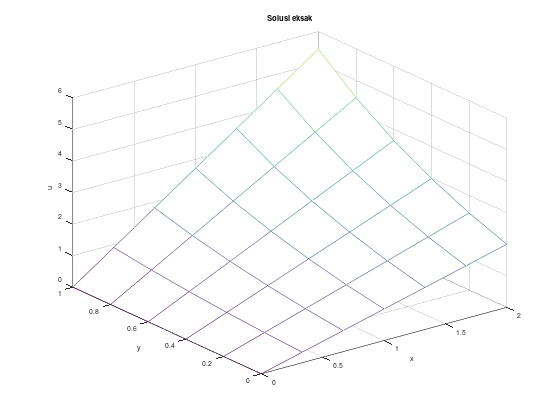

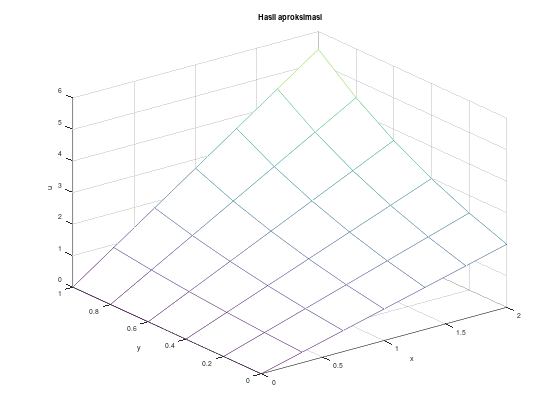

In [7]:
db = @(x,y) x;
ub = @(x,y) e * x;
lb = @(x,y) 0;
rb = @(x,y) 2 * exp(y);
f = @(x,y) x .* exp(y);
xb = 0;
xu = 2;
yb = 0;
yu = 1;
m = 6;
N = 5;
h = (xu - xb)/m; % rumus step size: h = (b-a)/m untuk interval a < x < b
k = (yu - yb)/N; % rumus step size: k = (d-c)/N untuk interval c < y < d
tol = 10^(-10);
M = 100;

[x_arr, y_arr, w] = eliptik_iteratif(db, ub, lb, rb, f, xb, xu, yb, yu, h, k, tol, M);

% solusi eksak
sln = @(x, y) x .* exp(y);
[x_grid, y_grid] = meshgrid(x_arr, y_arr);
u_eksak = sln(x_grid, y_grid);

% menampilkan nilai aproksimasi dalam bentuk seperi grid
disp("Grid nilai aproksimasi:");
disp(flipud(w'));

% menampilkan grid solusi eksak
disp("Grid solusi eksak:");
disp(flipud(u_eksak));

% perhitungan error
err_grid = abs(w' - u_eksak); % absolute error
err_total = sum(sum(err_grid)); % norm L1 (taxicab/Manhattan)
disp("Grid nilai error:");
disp(flipud(err_grid));
printf("Error total (norm L1): %d\n", err_total);

% gambar mesh hasil aproksimasi
figure 1;
mesh(x_arr, y_arr, w');
title("Hasil aproksimasi");
xlabel("x");
ylabel("y");
zlabel("u");

% gambar mesh solusi eksak
figure 2;
mesh(x_arr, y_arr, u_eksak);
title("Solusi eksak");
xlabel("x");
ylabel("y");
zlabel("u");

## PDP Hiperbolik / Persamaan Gelombang

### Bentuk umum, ide utama, penyederhanaan

### *Function file*

### Contoh soal